Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, None, 784)]       0         
_________________________________________________________________
Dense_1 (Dense)              (None, None, 64)          50176     
_________________________________________________________________
output (Dense)               (None, None, 10)          650       
Total params: 50,826
Trainable params: 50,826
Non-trainable params: 0
_________________________________________________________________
None


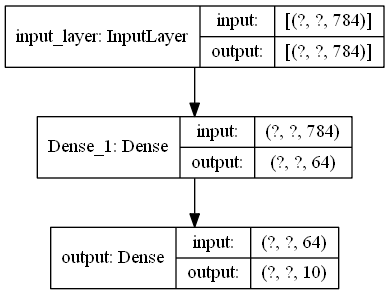

In [1]:
from tensorflow import keras

Input = keras.Input(shape=(None, 784),
                    name='input_layer',
                    dtype='int32')
dense = keras.layers.Dense(units=64, activation=keras.activations.relu, name='Dense_1',
                           use_bias=False, kernel_regularizer=keras.regularizers.l2(0.3))(Input)
output = keras.layers.Dense(units=10, activation=keras.activations.softmax, name='output')(dense)

model = keras.models.Model(inputs=[Input], outputs=[output], name='my_model')

print(model.summary())
keras.utils.plot_model(model, 'my_model.png',
                       show_layer_names=True, show_shapes=True)

In [2]:
# 保存了模型的完整信息，包括compile里的内容，以及训练情况等

model.save('save_model.h5')
del model
model = keras.models.load_model('save_model.h5')

In [3]:
# 一个layer可以用于构造多个模型

input_2 = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
                        activation=keras.activations.relu)(input_2)
encoder_output = keras.layers.GlobalMaxPool2D()(x)

encoder = keras.models.Model(inputs=[input_2], outputs=[encoder_output], name='encoder')
print(encoder.summary())

x = keras.layers.Reshape(target_shape=(4, 4, 1))(encoder_output)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), name='CT_1',
                                 activation=keras.activations.relu)(x)
x = keras.layers.UpSampling2D(size=(3, 3))(x)
x = keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3))(x)
decoder_output = keras.layers.LeakyReLU(name='Leak_Relu_1')(x)

autoencoder = keras.models.Model(inputs=[input_2], outputs=[decoder_output], name='autoencoder')
print(autoencoder.summary())


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0         
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
___________________________________

Model: "AD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_img (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None
Model: "en_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)            129         input_8[0][0]                    
__________

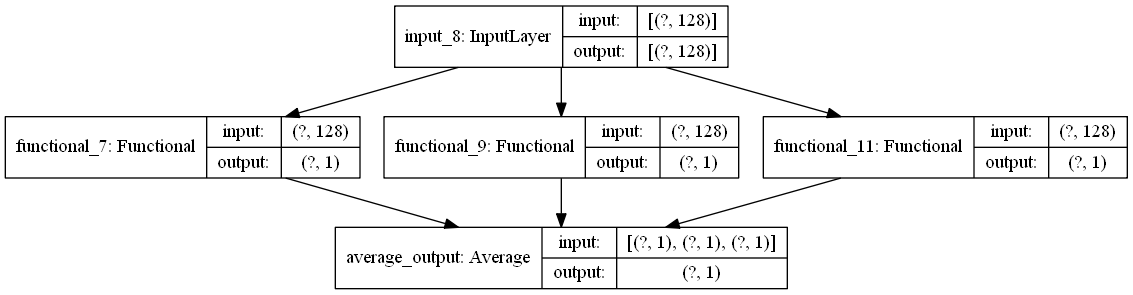

In [5]:
# 模型也可以被当作layer一样来调用、构造

autoencoder_input = keras.Input(shape=(28, 28, 1),
                                name='autoencoder_img')
encoder_img = encoder(autoencoder_input)
autoencoder = keras.models.Model(autoencoder_input, encoder_img, name='AD')
print(autoencoder.summary())

# 例如 将3个模型集成成一个模型，用他们的平均值做预测
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = keras.layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)

model_1 = get_model()
model_2 = get_model()
model_3 = get_model()
en_input = keras.Input(shape=(128, ))
out_1 = model_1(en_input)
out_2 = model_2(en_input)
out_3 = model_3(en_input)
outputs = keras.layers.Average(name='average_output')([out_1, out_2, out_3])
ensemble_model = keras.models.Model([en_input], [outputs], name='en_model')
print(ensemble_model.summary())
keras.utils.plot_model(ensemble_model, 'en_model.png',
                       show_shapes=True, show_layer_names=True)

In [3]:
from tensorflow import keras
import numpy as np

# 构造多输入多输出的复杂拓扑图，其关键在于，何种方式将多个输入组合成一个
num_tags = 12
num_words = 10000
num_departments = 4

title_input = keras.Input(shape=(None, ), name="title")
body_input = keras.Input(shape=(None,), name="body")
tags_input = keras.Input(shape=(num_tags, ), name="tags")

title_features = keras.layers.Embedding(num_words, 64)(title_input)
body_features = keras.layers.Embedding(num_words, 64)(body_input)

title_features = keras.layers.LSTM(units=128, return_sequences=False)(title_features)
body_features = keras.layers.LSTM(units=32, return_sequences=False)(body_features)

# 关键在这
x = keras.layers.Concatenate()([title_features, body_features, tags_input])

priority_pred = keras.layers.Dense(units=1, name='priority')(x)
department_pred = keras.layers.Dense(num_departments, name='department')(x)

model = keras.models.Model(inputs=[title_input, body_input, tags_input],
                           outputs=[priority_pred, department_pred],
                           name='satis_model')
print(model.summary())
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# 为不同输出指定损失，及权重，可用列表或者字典
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss={'priority': keras.losses.BinaryCrossentropy(from_logits=True, name='prior_loss'),
                    'department': keras.losses.CategoricalCrossentropy(from_logits=True, name='depart_loss')},
              loss_weights={'priority': 1.0,
                            'department': 0.2})


# 当训练的时候，也根据层的名字，来指定对应的输入输出数据

title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32)


Model: "satis_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     640000      body[0][0]                       
________________________________________________________________________________________

In [ ]:

# 共享层，即在同一模型中可以多次重用的层，他们学习的更广泛
# 这是一个词嵌入层的例子，在某个输入中看到给定的单词，则可以通过共享层处理所有输入
shared_embedding = keras.layers.Embedding(1000, 128)

text_input_a = keras.Input(shape=(None,), dtype="int32")
text_input_b = keras.Input(shape=(None,), dtype="int32")

encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)


In [5]:
# 提取和重用图中的节点
# 我们可以自由访问图中任何层的输出
vgg19 = keras.applications.VGG19()
feature_list = [layer.output for layer in vgg19.layers]
tion_model = keras.models.Model(inputs=vgg19.input, outputs=feature_list)
print(tion_model.summary())

211247104/574710816 [==========>...................] - ETA: 8:07   

KeyboardInterrupt: 

In [7]:

# 如果想复刻某个模型，但参数庞杂，则可以直接调取其config信息来构造
# 在无自己写的层时，只给config即可，否则还要通过custom_objects参数拓展keras Functional API，详见文档
config = model.get_config()
print(config)
new_model = keras.models.Model.from_config(config=config)
print(new_model.summary())


{'name': 'satis_model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'title'}, 'name': 'title', 'inbound_nodes': []}, {'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'body'}, 'name': 'body', 'inbound_nodes': []}, {'class_name': 'Embedding', 'config': {'name': 'embedding_2', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 64, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}, 'name': 'embedding_2', 'inbound_nodes': [[['title', 0, 0, {}]]]}, {'class_name': 'Embedding', 'config': {'name': 'embedding_3', 'trainable': True, 'batch_input_shape':